## CreditOne Modeling and Prediction 

### PROBLEM STATEMENT 

An increase in customer default rates is bad for Credit One since its business is approving customers for loans in the first place. This is likely to result in the loss of Credit One's business customers.

### OBJECTIVE
* To compute the predictive accuracy of probability of default for a Taiwanese credit card client.
* Classify probability of default for next month 1: DEFAULT and 0: NON-DEFAULT


In [2]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from math import sqrt
import pickle
import warnings
warnings.filterwarnings('ignore')

In [178]:
#cross validation
from sklearn.model_selection import train_test_split
#Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
#model metrics
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import  accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA


### Importing dataset

In [4]:
CreditOneNew = pd.read_csv('CreditOne_New.csv', header = 1 )

In [5]:
CreditOneNew

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,Age,Limit_Bal
0,0,20000,2,2,1,24,2,2,-1,-1,...,0,0,689,0,0,0,0,1,20,100000
1,1,120000,2,2,2,26,-1,2,0,0,...,3261,0,1000,1000,1000,0,2000,1,20,200000
2,2,90000,2,2,2,34,0,0,0,0,...,15549,1518,1500,1000,1000,1000,5000,0,30,100000
3,3,50000,2,2,1,37,0,0,0,0,...,29547,2000,2019,1200,1100,1069,1000,0,30,100000
4,4,50000,1,2,1,57,-1,0,-1,0,...,19131,2000,36681,10000,9000,689,679,0,50,100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29995,220000,1,3,1,39,0,0,0,0,...,15980,8500,20000,5003,3047,5000,1000,0,30,300000
29996,29996,150000,1,3,2,43,-1,-1,-1,-1,...,0,1837,3526,8998,129,0,0,0,40,200000
29997,29997,30000,1,2,2,37,4,3,2,-1,...,19357,0,0,22000,4200,2000,3100,1,30,100000
29998,29998,80000,1,3,1,41,1,-1,0,0,...,48944,85900,3409,1178,1926,52964,1804,1,40,100000


### Data Pre-Processing 

In [6]:
CreditOneNew.drop('ID', axis = 1, inplace =True) # drop column "ID"
CreditOneNew.drop('AGE', axis = 1, inplace =True) # drop column "original Age"
CreditOneNew.drop('LIMIT_BAL', axis = 1, inplace =True) # drop column "original Limit Bal"

In [7]:
CreditOneNew.rename(columns = {'default payment next month':'Default'}, inplace = True)

In [8]:
CreditOneNew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
SEX          30000 non-null int64
EDUCATION    30000 non-null int64
MARRIAGE     30000 non-null int64
PAY_0        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null int64
BILL_AMT2    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT4    30000 non-null int64
BILL_AMT5    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
Default      30000 non-null int64
Age          30000 non-null int64
Limit_Bal    30000 non-null int64
dtypes: int64(24)
memory usage: 5.5 MB


### Exploratory Data Analysis

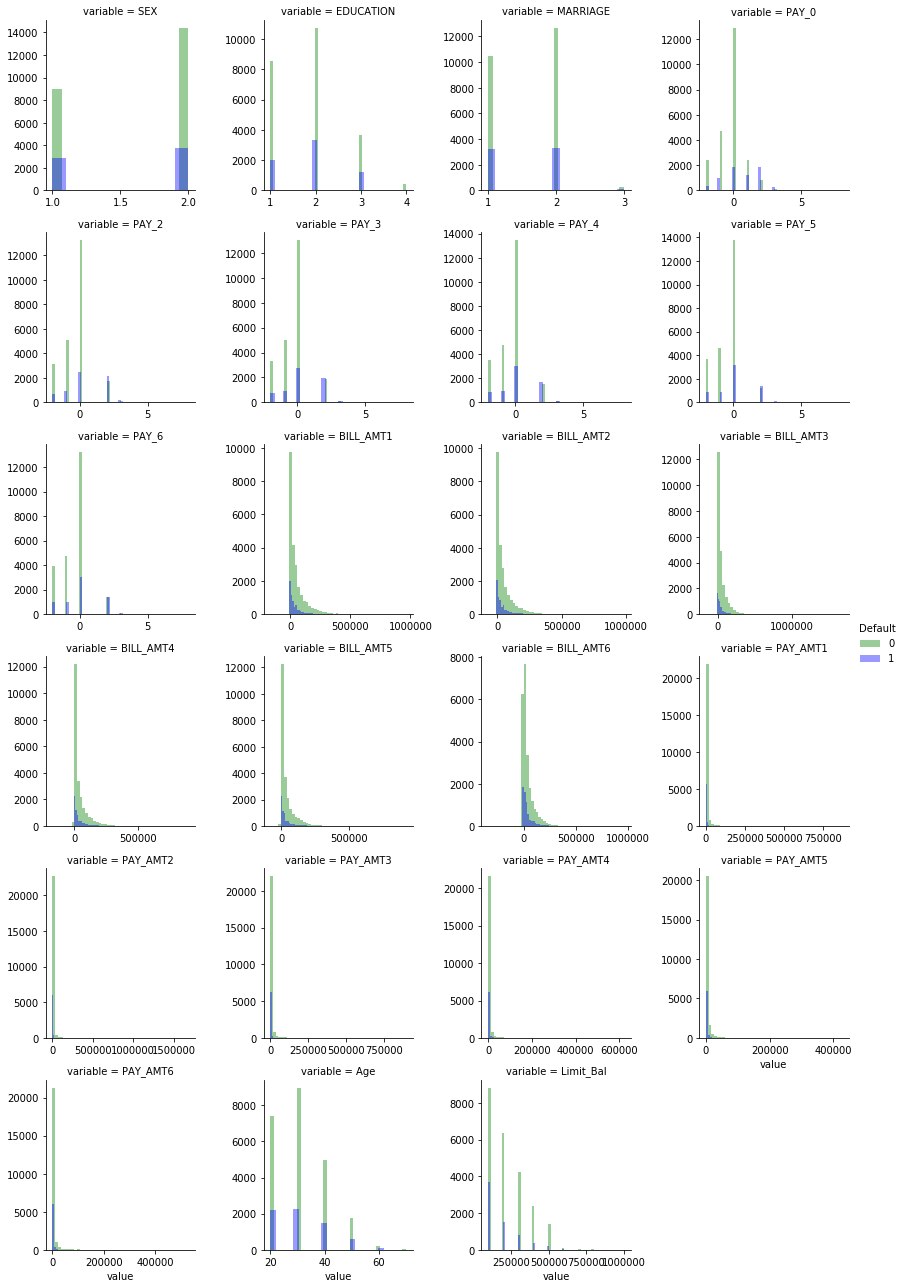

In [146]:
output = 'Default'
cols = [ f for f in CreditOneNew.columns if CreditOneNew.dtypes[ f ] != "object"]
cols.remove( output ) # removing the client's behavior
f = pd.melt(CreditOneNew , id_vars = output , value_vars=cols)#reshaping data(gathering columns into rows)
d = {'color': ['g', 'b']}
g = sns.FacetGrid( f, hue=output,hue_kws=d, col="variable", col_wrap=4, sharex=False, sharey=False )
g = g.map( sns.distplot, "value", kde=False,hist = True).add_legend()
plt.show(g)

#### Observation of Independent variables Vs Target Variable
* LIMIT_BAL: The lower the amount of given credit limit, the higher chance to default.
* SEX: Gender (1=male, 2=female): Females tend to default more than males.
* EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others): University/graduate levels tend to default more than other educational levels.
* MARRIAGE: (1=married, 2=single, 3=others): Married/single have more chance to default.
* AGE: The biggest chance of default is in the age group under 20-40.
* PAY_0-6: Having a delay, for 2 months or more increases the chance of default.
* BILL_AMT1-6: The smaller the difference between the amount owed on the bill, the bigger the chances to default.
* PAY_AMT1-6: The smaller the payment amount, the bigger the chance of default.


### Correlation Matrix

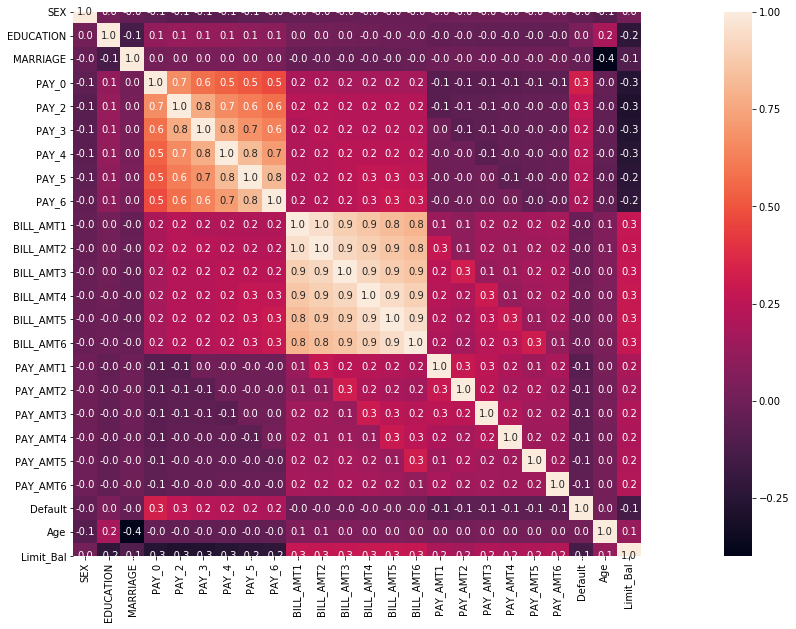

In [9]:
### Correlation Matrix
Correlation = CreditOneNew.corr()
Correlation
plt.subplots(figsize=(30,10))
sns.heatmap(Correlation, square=True, annot=True, fmt=".1f" )

### Correlation of features with target variable

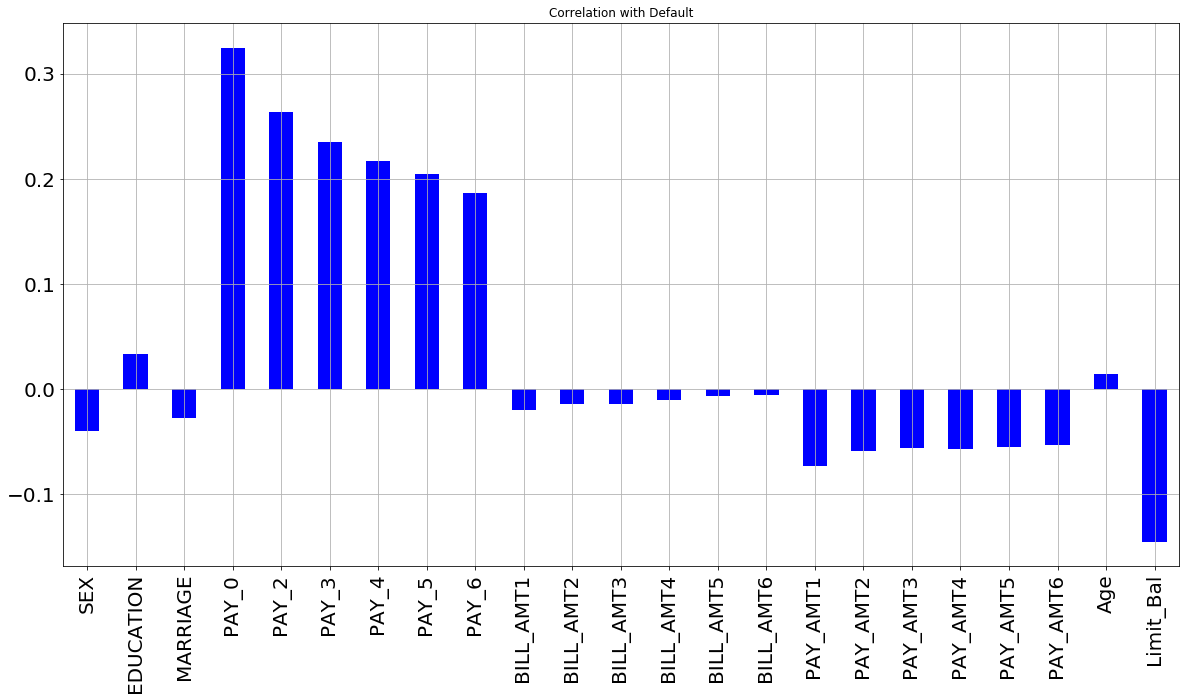

In [10]:
X = CreditOneNew.drop(['Default'],axis=1)
X.corrwith(CreditOneNew['Default']).plot.bar(figsize = (20, 10), title = "Correlation with Default", color = 'b',
                                        fontsize = 20,rot = 90, grid = True)

### Covariance Estimation

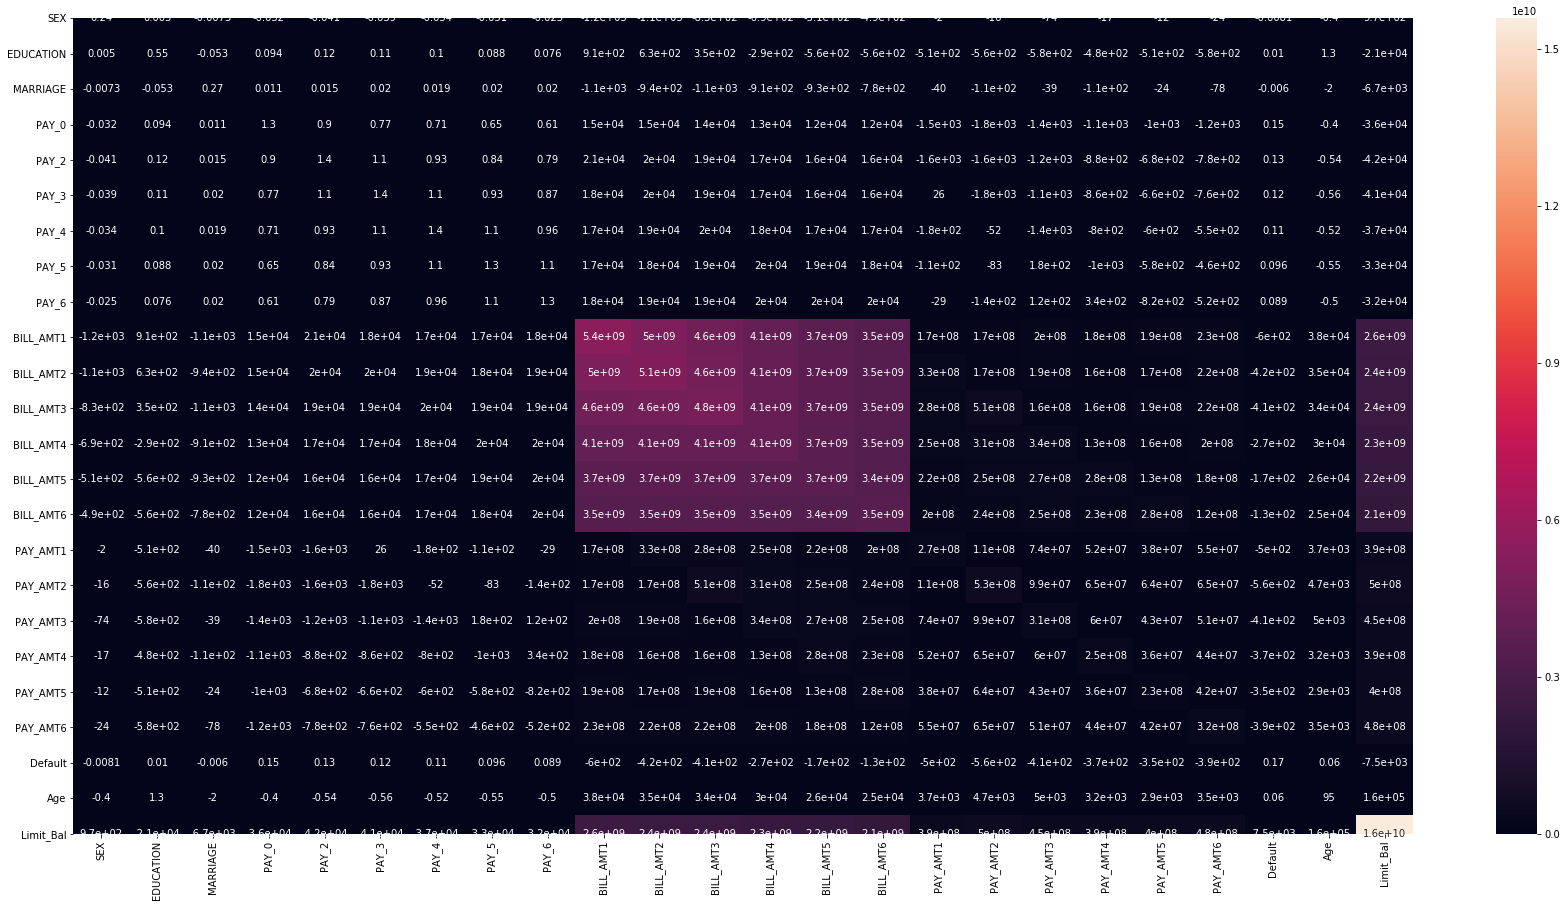

In [11]:
#Co-Variance
Covariance = CreditOneNew.cov()
plt.figure(figsize = (30,15))
sns.heatmap(Covariance,xticklabels=Covariance.columns, yticklabels=Covariance.columns, annot=True)

#### Limit_Balance is highly negatively orrelated with the target variable. Repayment status is highly positively correlated. 

#### Changing the data type for categorical variables

In [12]:
CreditOneNew['SEX'] = CreditOneNew['SEX'].astype('category')
CreditOneNew['EDUCATION'] = CreditOneNew['EDUCATION'].astype('category')
CreditOneNew['MARRIAGE'] = CreditOneNew['MARRIAGE'].astype('category')
CreditOneNew['PAY_0'] = CreditOneNew['PAY_0'].astype('category')
CreditOneNew['PAY_2'] = CreditOneNew['PAY_2'].astype('category')
CreditOneNew['PAY_3'] = CreditOneNew['PAY_3'].astype('category')
CreditOneNew['PAY_4'] = CreditOneNew['PAY_4'].astype('category')
CreditOneNew['PAY_5'] = CreditOneNew['PAY_5'].astype('category')
CreditOneNew['PAY_6'] = CreditOneNew['PAY_6'].astype('category')

### One Hot Encoding/Dummy Variables for categorical variable
The below categorical features are encoded with integer values 

In [13]:
#Make a list of categorical columns
categorical_vars = ['SEX', 'EDUCATION', 'MARRIAGE', 
                    'PAY_0', 'PAY_2', 'PAY_3', 
                   'PAY_4', 'PAY_5', 'PAY_6']
categorical_vars 

#CreditOneNew[categorical_vars] = CreditOneNew[categorical_vars].astype('object')
CreditOneNew[categorical_vars]

CreditOneNew = pd.get_dummies(CreditOneNew, 
                         columns=categorical_vars, 
                         drop_first=True)
CreditOneNew



,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,...,PAY_5_8,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
0,3913,3102,689,0,0,0,0,689,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,...,0,0,0,1,0,0,0,0,0,0
2,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,...,0,0,1,0,0,0,0,0,0,0
3,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,...,0,0,1,0,0,0,0,0,0,0
4,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,...,0,0,1,0,0,0,0,0,0,0
29996,1683,1828,3502,8979,5190,0,1837,3526,8998,129,...,0,0,1,0,0,0,0,0,0,0
29997,3565,3356,2758,20878,20582,19357,0,0,22000,4200,...,0,0,1,0,0,0,0,0,0,0
29998,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,...,0,1,0,0,0,0,0,0,0,0


In [505]:
CreditOneNew.columns


Index(['Default', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'Age', 'Limit_Bal', 'SEX_2',
       'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4', 'MARRIAGE_2', 'MARRIAGE_3',
       'PAY_0_-1', 'PAY_0_0', 'PAY_0_1', 'PAY_0_2', 'PAY_0_3', 'PAY_0_4',
       'PAY_0_5', 'PAY_0_6', 'PAY_0_7', 'PAY_0_8', 'PAY_2_-1', 'PAY_2_0',
       'PAY_2_1', 'PAY_2_2', 'PAY_2_3', 'PAY_2_4', 'PAY_2_5', 'PAY_2_6',
       'PAY_2_7', 'PAY_2_8', 'PAY_3_-1', 'PAY_3_0', 'PAY_3_1', 'PAY_3_2',
       'PAY_3_3', 'PAY_3_4', 'PAY_3_5', 'PAY_3_6', 'PAY_3_7', 'PAY_3_8',
       'PAY_4_-1', 'PAY_4_0', 'PAY_4_1', 'PAY_4_2', 'PAY_4_3', 'PAY_4_4',
       'PAY_4_5', 'PAY_4_6', 'PAY_4_7', 'PAY_4_8', 'PAY_5_-1', 'PAY_5_0',
       'PAY_5_2', 'PAY_5_3', 'PAY_5_4', 'PAY_5_5', 'PAY_5_6', 'PAY_5_7',
       'PAY_5_8', 'PAY_6_-1', 'PAY_6_0', 'PAY_6_2', 'PAY_6_3', 'PAY_6_4',
       'PAY_6_5', 'PAY_6_6', 'PAY_6_7', 'PAY_6

### Standardization
Transformed these attributes and age and Limit Bal to have a mean of zero and a standard deviation of 1

In [15]:
Col_2_Std = ['Limit_Bal', 'Age', 'BILL_AMT1', 'BILL_AMT2' ,'BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
               'PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
#Std_X = preprocessing.scale(Col_2_Std)
CreditOneNew[Col_2_Std] = CreditOneNew[Col_2_Std].apply(lambda x : (x-np.mean(x))/np.std(x))

In [411]:
CreditOneNew[Col_2_Std]

,Limit_Bal,Age,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,-0.902261,-1.114813,-0.642501,-0.647399,-0.667993,-0.672497,-0.663059,-0.652724,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382
1,-0.101461,-1.114813,-0.659219,-0.666747,-0.639254,-0.621636,-0.606229,-0.597966,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878
2,-0.902261,-0.087967,-0.298560,-0.493899,-0.482408,-0.449730,-0.417188,-0.391630,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122
3,-0.902261,-0.087967,-0.057491,-0.013293,0.032846,-0.232373,-0.186729,-0.156579,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130
4,-0.902261,1.965726,-0.578618,-0.611318,-0.161189,-0.346997,-0.348137,-0.331482,-0.221191,1.335034,0.271165,0.266434,-0.269039,-0.255187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.699338,-0.087967,1.870379,2.018136,2.326690,0.695474,-0.149259,-0.384392,0.171250,0.611048,-0.012648,-0.113564,0.013131,-0.237130
29996,-0.101461,0.938880,-0.672786,-0.665299,-0.627430,-0.532924,-0.577691,-0.652724,-0.231032,-0.103955,0.214255,-0.299828,-0.314136,-0.293382
29997,-0.902261,-0.087967,-0.647227,-0.643830,-0.638158,-0.347961,-0.324517,-0.327687,-0.341942,-0.256990,0.952725,-0.039964,-0.183229,-0.119001
29998,-0.902261,0.938880,-0.717982,0.410269,0.422373,0.147844,-0.468063,0.169130,4.844316,-0.109033,-0.229895,-0.185120,3.152536,-0.191904


In [16]:
CreditOneNew

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,...,PAY_5_8,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
0,-0.642501,-0.647399,-0.667993,-0.672497,-0.663059,-0.652724,-0.341942,-0.227086,-0.296801,-0.308063,...,0,0,0,0,0,0,0,0,0,0
1,-0.659219,-0.666747,-0.639254,-0.621636,-0.606229,-0.597966,-0.341942,-0.213588,-0.240005,-0.244230,...,0,0,0,1,0,0,0,0,0,0
2,-0.298560,-0.493899,-0.482408,-0.449730,-0.417188,-0.391630,-0.250292,-0.191887,-0.240005,-0.244230,...,0,0,1,0,0,0,0,0,0,0
3,-0.057491,-0.013293,0.032846,-0.232373,-0.186729,-0.156579,-0.221191,-0.169361,-0.228645,-0.237846,...,0,0,1,0,0,0,0,0,0,0
4,-0.578618,-0.611318,-0.161189,-0.346997,-0.348137,-0.331482,-0.221191,1.335034,0.271165,0.266434,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,1.870379,2.018136,2.326690,0.695474,-0.149259,-0.384392,0.171250,0.611048,-0.012648,-0.113564,...,0,0,1,0,0,0,0,0,0,0
29996,-0.672786,-0.665299,-0.627430,-0.532924,-0.577691,-0.652724,-0.231032,-0.103955,0.214255,-0.299828,...,0,0,1,0,0,0,0,0,0,0
29997,-0.647227,-0.643830,-0.638158,-0.347961,-0.324517,-0.327687,-0.341942,-0.256990,0.952725,-0.039964,...,0,0,1,0,0,0,0,0,0,0
29998,-0.717982,0.410269,0.422373,0.147844,-0.468063,0.169130,4.844316,-0.109033,-0.229895,-0.185120,...,0,1,0,0,0,0,0,0,0,0


### Moving Default to the begining of the dataframe 

In [17]:
# Get the current list of columns names
col_names = list(CreditOneNew)
col_names.insert(0, col_names.pop(col_names.index('Default')))
CreditOneNew = CreditOneNew.loc[:, col_names]

### Selecting and Divinding the data
Spliting Dataset into training(70%) and test set(30%)

In [19]:
X=CreditOneNew.iloc[:,1:79].values
y=CreditOneNew.iloc[:,0].values

In [20]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 50)


In [21]:
X_train.shape

(21000, 78)

In [482]:
columns_ = CreditOneNew.iloc[:,1:79].columns


Index(['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
       'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6', 'Age', 'Limit_Bal', 'SEX_2', 'EDUCATION_2', 'EDUCATION_3',
       'EDUCATION_4', 'MARRIAGE_2', 'MARRIAGE_3', 'PAY_0_-1', 'PAY_0_0',
       'PAY_0_1', 'PAY_0_2', 'PAY_0_3', 'PAY_0_4', 'PAY_0_5', 'PAY_0_6',
       'PAY_0_7', 'PAY_0_8', 'PAY_2_-1', 'PAY_2_0', 'PAY_2_1', 'PAY_2_2',
       'PAY_2_3', 'PAY_2_4', 'PAY_2_5', 'PAY_2_6', 'PAY_2_7', 'PAY_2_8',
       'PAY_3_-1', 'PAY_3_0', 'PAY_3_1', 'PAY_3_2', 'PAY_3_3', 'PAY_3_4',
       'PAY_3_5', 'PAY_3_6', 'PAY_3_7', 'PAY_3_8', 'PAY_4_-1', 'PAY_4_0',
       'PAY_4_1', 'PAY_4_2', 'PAY_4_3', 'PAY_4_4', 'PAY_4_5', 'PAY_4_6',
       'PAY_4_7', 'PAY_4_8', 'PAY_5_-1', 'PAY_5_0', 'PAY_5_2', 'PAY_5_3',
       'PAY_5_4', 'PAY_5_5', 'PAY_5_6', 'PAY_5_7', 'PAY_5_8', 'PAY_6_-1',
       'PAY_6_0', 'PAY_6_2', 'PAY_6_3', 'PAY_6_4', 'PAY_6_5', 'PAY_6_6',
       'PAY_6_7', 'PAY_6_8'],
     

In [23]:
X_test.shape

(9000, 78)

### Applying Machine Learning Algorithm for Classification Problem

### Baseline Algorithms

## Model 1: Decision Tree

In [179]:
ModelDT = DecisionTreeClassifier(random_state=50)

In [180]:
%%timeit -n 1 -r 5
ModelDT.fit(X_train,y_train)

1.14 s ± 64.4 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [402]:
print(cross_val_score(ModelDT, X_train, y_train))
ScoreDT = cross_val_score(ModelDT, X_train, y_train)
print("Accuracy: %0.4f (+/- %0.4f)" % (ScoreDT.mean(), ScoreDT.std() * 2))

[0.71742857 0.72357143 0.72385714]
Accuracy: 0.7216 (+/- 0.0059)


In [185]:
# save the model to disk
filename = 'ModelDT.sav'
Pickle_on = open(filename, 'wb')
pickle.dump(ModelDT, Pickle_on)
Pickle_on.close()

In [403]:
# load the model from disk
filename = 'ModelDT.sav'
Pickle_off = open(filename, 'rb')
Pickeled_DT = pickle.load(Pickle_off)
Pickle_off.close()
result = Pickeled_DT.score(X_test, y_test)
print(result)

0.7291111111111112


In [404]:
# make class predictions for the testing set
DT_Prediction = Pickeled_DT.predict(X_test)

In [405]:
print(metrics.accuracy_score(y_test, DT_Prediction))
print(metrics.confusion_matrix(y_test, DT_Prediction))
print(metrics.classification_report(DT_Prediction, y_test))

0.7291111111111112
[[5776 1298]
 [1140  786]]
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      6916
           1       0.41      0.38      0.39      2084

    accuracy                           0.73      9000
   macro avg       0.61      0.61      0.61      9000
weighted avg       0.72      0.73      0.73      9000



In [442]:
Mean_Scores  = ScoreDT.mean()
roc=roc_auc_score(y_test, DT_Prediction)
acc = accuracy_score(y_test, DT_Prediction)
prec = precision_score(y_test, DT_Prediction)
rec = recall_score(y_test, DT_Prediction)
f1 = f1_score(y_test, DT_Prediction)

DT_result= pd.DataFrame([['DECISION TREE', Mean_Scores,acc,prec,rec, f1,roc]],
               columns = ['Model', 'Train Accuracy','Test Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])

model_results = model_results.append(DT_result, ignore_index = True)
DT_result

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC
0,DECISION TREE,0.721619,0.729111,0.377159,0.4081,0.39202,0.612305


## Model 2: Random Forest 

In [25]:
ModelRf = RandomForestClassifier(random_state = 50)

In [27]:
%%timeit -n 1 -r 5
ModelRf.fit(X_train,y_train)

946 ms ± 22.5 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [400]:
print(cross_val_score(ModelRf, X_train, y_train))
ScoreRF  = cross_val_score(ModelRf, X_train, y_train)
print("Accuracy: %0.5f (+/- %0.2f)" % (ScoreRF.mean(), ScoreRF.std() * 2))


[0.79928571 0.80314286 0.809     ]
Accuracy: 0.80381 (+/- 0.01)


In [37]:
# save the model to disk
filename = 'ModelRf.sav'
Pickle_on = open(filename, 'wb')
pickle.dump(ModelRf, Pickle_on)
pickle_on.close()


In [188]:
# load the model from disk
filename = 'ModelRf.sav'
Pickle_off = open(filename, 'rb')
Pickeled_RF = pickle.load(Pickle_off)
Pickle_off.close()
result = Pickeled_RF.score(X_test, y_test)
print(result)

0.8081111111111111


In [190]:
# make class predictions for the testing set
RF_Prediction = Pickeled_RF.predict(X_test)

In [73]:
print(metrics.accuracy_score(y_test, RF_Prediction))
print(metrics.confusion_matrix(y_test, RF_Prediction))
print(metrics.classification_report(RF_Prediction, y_test))

0.8081111111111111
[[6641  433]
 [1294  632]]
              precision    recall  f1-score   support

           0       0.94      0.84      0.88      7935
           1       0.33      0.59      0.42      1065

    accuracy                           0.81      9000
   macro avg       0.63      0.72      0.65      9000
weighted avg       0.87      0.81      0.83      9000



In [441]:
Mean_scores = ScoreRF.mean()
roc=roc_auc_score(y_test, RF_Prediction)
acc = accuracy_score(y_test, RF_Prediction)
prec = precision_score(y_test, RF_Prediction)
rec = recall_score(y_test, RF_Prediction)
f1 = f1_score(y_test, RF_Prediction)

model_results= pd.DataFrame([['RANDOM FOREST',Mean_scores,acc,prec,rec, f1,roc]],
               columns = ['Model', 'Train Accuracy','Test Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])

model_results

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC
0,RANDOM FOREST,0.80381,0.808111,0.593427,0.328141,0.422601,0.633466


## Model 3: Support Vector Machine

In [274]:
ModelSVM= SVC(kernel = 'linear',probability= True, random_state = 50)

In [275]:
%%timeit -n 1 -r 5
ModelSVM.fit(X_train,y_train)

5min 25s ± 49.2 s per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [407]:
print(cross_val_score(ModelSVM, X_train, y_train))
ScoreSVM  = cross_val_score(ModelSVM, X_train, y_train)
print("Accuracy: %0.5f (+/- %0.5f)" % (ScoreSVM.mean(), ScoreSVM.std() * 2))


[0.818      0.81485714 0.81757143]
Accuracy: 0.81681 (+/- 0.00278)


In [277]:
# save the model to disk
filename = 'ModelSVM.sav'
Pickle_on = open(filename, 'wb')

pickle.dump(ModelSVM, Pickle_on)
Pickle_on.close()


In [408]:
# load the model from disk
filename = 'ModelSVM.sav'
Pickle_off = open(filename, 'rb')
Pickeled_SVM = pickle.load(Pickle_off)
Pickle_off.close()
result = Pickeled_SVM.score(X_test, y_test)
print(result)

0.8251111111111111


In [409]:
SVM_Prediction = Pickeled_SVM.predict(X_test)

In [410]:
print(metrics.accuracy_score(y_test, SVM_Prediction))
print(metrics.confusion_matrix(y_test, SVM_Prediction))
print(metrics.classification_report(SVM_Prediction, y_test))

0.8251111111111111
[[6793  281]
 [1293  633]]
              precision    recall  f1-score   support

           0       0.96      0.84      0.90      8086
           1       0.33      0.69      0.45       914

    accuracy                           0.83      9000
   macro avg       0.64      0.77      0.67      9000
weighted avg       0.90      0.83      0.85      9000



In [443]:
Mean_scores = ScoreSVM.mean()
roc=roc_auc_score(y_test, SVM_Prediction)
acc = accuracy_score(y_test, SVM_Prediction)
prec = precision_score(y_test, SVM_Prediction)
rec = recall_score(y_test, SVM_Prediction)
f1 = f1_score(y_test, SVM_Prediction)

SVM_result = pd.DataFrame([['SUPPORT VECTOR MACHINE',Mean_scores, acc,prec,rec, f1,roc]],
               columns = ['Model', 'Train Accuracy','Test Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])
model_results = model_results.append(SVM_result, ignore_index = True)
SVM_result

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC
0,SUPPORT VECTOR MACHINE,0.81681,0.825111,0.69256,0.32866,0.445775,0.644469


## Model 4: K-Nearest Neighbor 

In [238]:
ModelKNN = KNeighborsClassifier()

In [120]:
%%timeit -n 1 -r 5
ModelKNN.fit(X_train,y_train)

212 ms ± 25.8 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [417]:
print(cross_val_score(ModelKNN, X_train, y_train))
ScoreKNN  = cross_val_score(ModelKNN, X_train, y_train)
print("Accuracy: %0.5f (+/- %0.5f)" % (ScoreKNN.mean(), ScoreKNN.std() * 2))


[0.79228571 0.78714286 0.79514286]
Accuracy: 0.79152 (+/- 0.00662)


In [122]:
# save the model to disk
filename = 'ModelKNN.sav'
Pickle_on = open(filename, 'wb')
pickle.dump(ModelKNN, Pickle_on)
Pickle_on.close()

0.7995555555555556


In [418]:
# load the model from disk
filename = 'ModelKNN.sav'
Pickle_off = open(filename, 'rb')
Pickeled_KNN = pickle.load(Pickle_off)
Pickeled_KNN
result = Pickeled_KNN.score(X_test, y_test)
print(result)

0.7995555555555556


In [419]:
KNN_Prediction = Pickeled_KNN.predict(X_test)

In [420]:
print(metrics.accuracy_score(y_test, KNN_Prediction))
print(metrics.confusion_matrix(y_test, KNN_Prediction))
print(metrics.classification_report(KNN_Prediction, y_test))

0.7995555555555556
[[6512  562]
 [1242  684]]
              precision    recall  f1-score   support

           0       0.92      0.84      0.88      7754
           1       0.36      0.55      0.43      1246

    accuracy                           0.80      9000
   macro avg       0.64      0.69      0.65      9000
weighted avg       0.84      0.80      0.82      9000



In [444]:
Mean_score = ScoreKNN.mean()
roc=roc_auc_score(y_test, KNN_Prediction)
acc = accuracy_score(y_test, KNN_Prediction)
prec = precision_score(y_test, KNN_Prediction)
rec = recall_score(y_test, KNN_Prediction)
f1 = f1_score(y_test, KNN_Prediction)
KNN_result= pd.DataFrame([['k-NEAREST NEIGHBOR', Mean_score,acc,prec,rec, f1,roc]],
               columns = ['Model', 'Train Accuracy','Test Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])
model_results = model_results.append(KNN_result, ignore_index = True)
KNN_result


,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC
0,k-NEAREST NEIGHBOR,0.791524,0.799556,0.548957,0.35514,0.431274,0.637847


## Model 5: Gradient Boosted Model

In [296]:
from sklearn.ensemble import GradientBoostingClassifier
ModelGB= GradientBoostingClassifier(random_state=50)


In [297]:
%%timeit -n 1 -r 5
ModelGB.fit(X_train,y_train)

15.6 s ± 2.08 s per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [333]:
print(cross_val_score(Pickeled_GB, X_train, y_train))


[0.81728571 0.81571429 0.81771429]
Accuracy: 0.81690 (+/- 0.00172)


In [503]:
Pickeled_GB

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [423]:
ScoreGB  = cross_val_score(Pickeled_GB, X_train, y_train)
print("Accuracy: %0.5f (+/- %0.5f)" % (ScoreGB.mean(), ScoreGB.std() * 2))

Accuracy: 0.81690 (+/- 0.00172)


In [ ]:
# save the model to disk
filename = 'ModelGB.sav'
Pickle_on = open(filename, 'wb')
pickle.dump(ModelGB, Pickle_on)
Pickle_on.close()

In [424]:
# load the model from disk
filename = 'ModelGB.sav'
Pickle_off = open(filename, 'rb')
Pickeled_GB = pickle.load(Pickle_off)
Pickle_off.close()
result = Pickeled_GB.score(X_test, y_test)
print(result)

0.8256666666666667


In [425]:
GB_Prediction = Pickeled_GB.predict(X_test)

In [426]:
print(metrics.accuracy_score(y_test, GB_Prediction))
print(metrics.confusion_matrix(y_test, GB_Prediction))
print(metrics.classification_report(GB_Prediction, y_test))

0.8256666666666667
[[6723  351]
 [1218  708]]
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      7941
           1       0.37      0.67      0.47      1059

    accuracy                           0.83      9000
   macro avg       0.66      0.76      0.68      9000
weighted avg       0.88      0.83      0.85      9000



In [445]:
Mean_score = ScoreGB.mean()
roc=roc_auc_score(y_test, GB_Prediction)
acc = accuracy_score(y_test, GB_Prediction)
prec = precision_score(y_test, GB_Prediction)
rec = recall_score(y_test, GB_Prediction)
f1 = f1_score(y_test, KNN_Prediction)
GB_result= pd.DataFrame([['Gradient Boosted Model', Mean_score,acc,prec,rec, f1,roc]],
               columns = ['Model', 'Train Accuracy','Test Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])
model_results = model_results.append(GB_result, ignore_index = True)
GB_result


,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC
0,Gradient Boosted Model,0.816905,0.825667,0.668555,0.367601,0.431274,0.658991


### Feature Importance of GBM model 
    From the above results dataframe we can see that GBM(81.6%) performed better than the other 4 models 

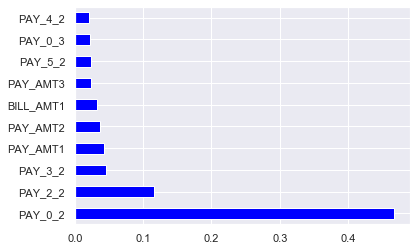

<Figure size 1440x1440 with 0 Axes>

In [470]:
feature_importances = pd.Series(Pickeled_GB.feature_importances_,index = columns_)
feature_importances.nlargest(10).plot(kind='barh',color = ['blue'])
plt.figure(figsize = (20,20))
plt.show()

### Recursive Feature Elimination

In [354]:
from sklearn.feature_selection import RFE
#clf = SVC(kernel = 'rbf',random_state = 50)
# create the RFE model for the GBM classifier 
# and select attributes
rfe = RFE(ModelGB, 10)
rfe = rfe.fit(X_train, y_train)
# print summaries for the selection of attributes
print(rfe.support_)
print(rfe.ranking_)

[ True  True False  True False False  True  True  True False False False
 False False False False False False False False False False False  True
 False False False False False False False False False  True False False
 False False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False  True False False False False False False False False False
 False False False False False False]
[ 1  1 10  1 11 12  1  1  1  6  8  9 14  3 20 23 45 15 24 61 26 17 16  1
  2 18 37 31 55 59 62 44 66  1  7 28 63 21 69 68 25 39 60  1 22 33 47 35
 54 48 49 29 40  5 41 36 65 53 51 64 50 27  1 32 30 38 52 42 56 34 43  4
 13 57 58 19 67 46]


In [337]:
print(cross_val_score(rfe, X_train, y_train))


[0.81357143 0.812      0.81571429]
Accuracy: 0.81376 (+/- 0.00304)


In [428]:
ScoreRFE  = cross_val_score(Pickeled_rfe, X_train, y_train)
print("Accuracy: %0.5f (+/- %0.5f)" % (ScoreRFE.mean(), ScoreRFE.std() * 2))

Accuracy: 0.81376 (+/- 0.00304)


In [ ]:
# save the model to disk
filename = 'rfe.sav'
Pickle_on = open(filename, 'wb')
pickle.dump(rfe, Pickle_on)
Pickle_on.close()

In [429]:
# load the model from disk
filename = 'rfe.sav'
Pickle_off = open(filename, 'rb')
Pickeled_rfe = pickle.load(Pickle_off)
Pickle_off.close()
result = Pickeled_rfe.score(X_test, y_test)
print(result)

0.8234444444444444


In [84]:
RFE_Prediction = Pickeled_rfe.predict(X_test)

In [430]:
print(metrics.accuracy_score(y_test, RFE_Prediction))
print(metrics.confusion_matrix(y_test, RFE_Prediction))
print(metrics.classification_report(RFE_Prediction, y_test))

0.8234444444444444
[[6729  345]
 [1244  682]]
              precision    recall  f1-score   support

           0       0.95      0.84      0.89      7973
           1       0.35      0.66      0.46      1027

    accuracy                           0.82      9000
   macro avg       0.65      0.75      0.68      9000
weighted avg       0.88      0.82      0.85      9000



In [484]:
Feature_imp = columns_
Feature_imp
print('Most important features (RFE): %s'% Feature_imp[Pickeled_rfe.support_])

Most important features (RFE): Index(['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT4', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_0_2', 'PAY_2_2', 'PAY_3_2', 'PAY_5_2'],
      dtype='object')


#### Above are the 10 most important features

In [446]:
Mean_score = ScoreRFE.mean()
roc=roc_auc_score(y_test, RFE_Prediction)
acc = accuracy_score(y_test, RFE_Prediction)
prec = precision_score(y_test, RFE_Prediction)
rec = recall_score(y_test, RFE_Prediction)
f1 = f1_score(y_test, RFE_Prediction)
RFE_result= pd.DataFrame([['Recursive Feature Elimination-GBM', Mean_score,acc,prec,rec, f1,roc]],
               columns = ['Model', 'Train Accuracy','Test Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])
model_results = model_results.append(RFE_result, ignore_index = True)
RFE_result

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC
0,Recursive Feature Elimination-GBM,0.813762,0.823444,0.66407,0.354102,0.461903,0.652666


### Prinicipal Component Analysis(PCA)

In [191]:
# Make an instance of the Model
pca = PCA(.95)
PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
#fitting PCA on the training set only

pca.fit(X_train)
#Applying the mapping (transform) to both the training set and the test set.
Train_PCA = pca.transform(X_train)
Test_PCA = pca.transform(X_test)

In [192]:
pca.n_components_

19

In [187]:
X_train.shape

(21000, 78)

In [189]:
Train_PCA.shape

(21000, 19)

####  From the above output, you can observe that to achieve 95% variance, the dimension was reduced to 19 principal components from the actual 78 dimensions.

In [364]:
#Use the model
#clf = SVC(kernel = 'rbf')
PCA_CLF = ModelGB.fit(X_train, y_train)

print(cross_val_score(PCA_CLF, X_train, y_train))

explained_variance = pca.explained_variance_ratio_


[0.81728571 0.81571429 0.81771429]


In [432]:
ScorePCA  = cross_val_score(Pickeled_PCA_CLF, X_train, y_train)
print("Accuracy: %0.5f (+/- %0.5f)" % (ScorePCA.mean(), ScorePCA.std() * 2))

Accuracy: 0.81690 (+/- 0.00172)


In [365]:
explained_variance

array([0.33790556, 0.11583334, 0.06615125, 0.05399442, 0.04908472,
       0.04793704, 0.04653531, 0.04326519, 0.04222678, 0.03712595,
       0.02259103, 0.01604036, 0.01550814, 0.01308746, 0.01231659,
       0.00958864, 0.00812832, 0.00726709, 0.00628612])

In [366]:
# save the model to disk
filename = 'PCA_CLF.sav'
Pickle_on = open(filename, 'wb')
pickle.dump(PCA_CLF, Pickle_on)
Pickle_on.close()


In [86]:
# load the model from disk
filename = 'PCA_CLF.sav'
Pickle_off = open(filename, 'rb')
Pickeled_PCA_CLF = pickle.load(Pickle_off)
result = Pickeled_PCA_CLF.score(X_test, y_test)
print(result)



0.8256666666666667


In [87]:
PCA_CLF_Pred = Pickeled_PCA_CLF.predict(X_test)
#print ('pred label:', clf.predict(X_test))

In [88]:
print(metrics.accuracy_score(y_test, PCA_CLF_Pred))
print(metrics.confusion_matrix(y_test, PCA_CLF_Pred))
print(metrics.classification_report(PCA_CLF_Pred, y_test))

0.8256666666666667
[[6723  351]
 [1218  708]]
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      7941
           1       0.37      0.67      0.47      1059

    accuracy                           0.83      9000
   macro avg       0.66      0.76      0.68      9000
weighted avg       0.88      0.83      0.85      9000



In [447]:
Mean_score = ScorePCA.mean()
roc=roc_auc_score(y_test, PCA_CLF_Pred)
acc = accuracy_score(y_test, PCA_CLF_Pred)
prec = precision_score(y_test, PCA_CLF_Pred)
rec = recall_score(y_test, PCA_CLF_Pred)
f1 = f1_score(y_test, PCA_CLF_Pred)

PCA_result= pd.DataFrame([['PCA-GBM', Mean_score,acc,prec,rec, f1,roc]],
               columns = ['Model', 'Train Accuracy','Test Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])
model_results = model_results.append(PCA_result, ignore_index = True)
PCA_result

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC
0,PCA-GBM,0.816905,0.825667,0.668555,0.367601,0.474372,0.658991


### MODEL HYPERPARAMETER TUNING

### Grid Search-Random Forest

In [151]:
%%timeit -n 1 -r 5
Param_grid_RF = {'n_estimators':[100, 300, 500, 800, 1000],
              'criterion': ['entropy', 'gini'],
              'bootstrap': [True,False]}
grid_search_RF = GridSearchCV(estimator=ModelRf,param_grid=Param_grid_RF,scoring='accuracy',cv=3,n_jobs=-1)
grid_search_RF = grid_search_RF.fit(X_train,y_train)


In [481]:
grid_search_RF

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='wa

In [152]:
best_accuracy_1 = grid_search_RF.best_score_
print('Accuracy on Cross Validation set :',best_accuracy_1)

Accuracy on Cross Validation set : 0.815


In [153]:
best_parameters_RF = grid_search_RF.best_params_
best_parameters_RF

{'bootstrap': True, 'criterion': 'gini', 'n_estimators': 1000}

In [ ]:
# save the model to disk
Pickle_on = open(filename, 'wb')

pickle.dump(grid_search_RF, Pickle_on)
Pickle_on.close()

In [90]:
# load the model from disk
filename = 'grid_search_RF.sav'
Pickle_off = open(filename, 'rb')
Pickeled_GS_RF = pickle.load(Pickle_off)
Pickle_off.close()
result = Pickeled_GS_RF.score(X_test, y_test)
print(result)

0.8213333333333334


In [91]:
RF_GS_Prediction = Pickeled_GS_RF.predict(X_test)

In [92]:
print(metrics.accuracy_score(y_test, RF_GS_Prediction))
print(metrics.confusion_matrix(y_test, RF_GS_Prediction))
print(metrics.classification_report(RF_GS_Prediction, y_test))

0.8213333333333334
[[6664  410]
 [1198  728]]
              precision    recall  f1-score   support

           0       0.94      0.85      0.89      7862
           1       0.38      0.64      0.48      1138

    accuracy                           0.82      9000
   macro avg       0.66      0.74      0.68      9000
weighted avg       0.87      0.82      0.84      9000



In [448]:
score = Pickeled_GS_RF.best_score_
roc=roc_auc_score(y_test, RF_GS_Prediction)
acc = accuracy_score(y_test, RF_GS_Prediction)
prec = precision_score(y_test, RF_GS_Prediction)
rec = recall_score(y_test, RF_GS_Prediction)
f1 = f1_score(y_test, RF_GS_Prediction)

RF_GS_result= pd.DataFrame([['Random Forest-GS-Tuned', score,acc,prec,rec, f1,roc]],
                 columns = ['Model', 'Train Accuracy','Test Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])
model_results = model_results.append(RF_GS_result, ignore_index = True)
RF_GS_result


,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC
0,Random Forest-GS-Tuned,0.815,0.821333,0.639719,0.377985,0.475196,0.660013



### Grid Search-Support Vector Machine

In [160]:
%%timeit -n 1 -r 5
Param_grid_SVM = [{'C':[0.1,1,10,100,1000],'kernel':['linear'],'gamma':[1,0.1,0.01,0.001,0.0001]}]
grid_search_SVM = GridSearchCV(estimator=ModelSVM,param_grid=Param_grid_SVM,scoring='accuracy',cv=3,n_jobs=-1)
grid_search_SVM = grid_search_SVM.fit(X_train,y_train)

In [162]:
best_accuracy_1 = grid_search_SVM.best_score_
print('Accuracy on Cross Validation set :',best_accuracy_1)

Accuracy on Cross Validation set : 0.817047619047619


In [163]:
best_parameters = grid_search_SVM.best_params_
best_parameters


{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}

In [ ]:
# save the model to disk
filename = 'grid_search_SVM.sav'
pickle.dump(, open(filename, 'wb'))
Pickle_on = open(filename, 'wb')
pickle.dump(grid_search_SVM, Pickle_on)
Pickle_on.close()


In [94]:
# load the model from disk
filename = 'grid_search_SVM.sav'
Pickle_off = open(filename, 'rb')
Pickeled_GS_SVM = pickle.load(Pickle_off)
Pickle_off.close()
result = Pickeled_GS_SVM.score(X_test, y_test)
print(result)

0.8253333333333334


In [95]:
SVM_GS_Prediction = Pickeled_GS_SVM.predict(X_test)

In [96]:
print(metrics.accuracy_score(y_test, SVM_GS_Prediction))
print(metrics.confusion_matrix(y_test, SVM_GS_Prediction))
print(metrics.classification_report(SVM_GS_Prediction, y_test))

0.8253333333333334
[[6795  279]
 [1293  633]]
              precision    recall  f1-score   support

           0       0.96      0.84      0.90      8088
           1       0.33      0.69      0.45       912

    accuracy                           0.83      9000
   macro avg       0.64      0.77      0.67      9000
weighted avg       0.90      0.83      0.85      9000



In [449]:
score = Pickeled_GS_SVM.best_score_
roc=roc_auc_score(y_test, SVM_GS_Prediction)
acc = accuracy_score(y_test, SVM_GS_Prediction)
prec = precision_score(y_test, SVM_GS_Prediction)
rec = recall_score(y_test, SVM_GS_Prediction)
f1 = f1_score(y_test, SVM_GS_Prediction)

SVM_GS_result= pd.DataFrame([['Support Vector Machine-GS-Tuned', score,acc,prec,rec, f1,roc]],
               columns = ['Model', 'Train Accuracy','Test Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])
model_results = model_results.append(SVM_GS_result, ignore_index = True)
SVM_GS_result

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC
0,Support Vector Machine-GS-Tuned,0.817048,0.825333,0.694079,0.32866,0.446089,0.64461


### Grid Search-K-Nearest Neighbors

In [102]:
k_range = list(range(1,31))
weight_options = ["uniform", "distance"]
Param_grid_KNN = dict(n_neighbors = k_range, weights = weight_options)
grid_search_KNN = GridSearchCV(estimator = Pickeled_KNN ,param_grid = Param_grid_KNN,scoring='accuracy',cv=3,n_jobs=-1)
grid_search_KNN =  grid_search_KNN.fit(X_train,y_train)

36min 24s ± 15min 43s per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [126]:
k_range = list(range(1,5))

In [127]:
leaf_size = list(range(1,5))

In [128]:
Param_grid_KNN = {'n_neighbors': k_range, 'leaf_size': leaf_size}

In [129]:
grid_search_KNN = GridSearchCV(estimator = Pickeled_KNN,param_grid = Param_grid_KNN,scoring='accuracy',cv=3,n_jobs=-1)

In [130]:
grid_search_KNN = grid_search_KNN.fit(X_train,y_train)

In [131]:
best_accuracy_1 = grid_search_KNN.best_score_
print('Accuracy on Cross Validation set :',best_accuracy_1)

Accuracy on Cross Validation set : 0.7933809523809524


In [ ]:
Accuracy_GS_KNN = cross_val_score(Pickeled_GS_KNN,X_train,y_train)
print(Accuracy_GS_KNN)

In [132]:
best_parameters = grid_search_KNN.best_params_
best_parameters

{'leaf_size': 2, 'n_neighbors': 4}

In [134]:
# save the model to disk
filename = 'grid_search_KNN.sav'
Pickle_on = open(filename, 'wb')
pickle.dump(grid_search_KNN, Pickle_on)
Pickle_on.close()

In [135]:
# load the model from disk
filename = 'grid_search_KNN.sav'
Pickle_off = open(filename, 'rb')
Pickeled_GS_KNN= pickle.load(Pickle_off)
Pickle_off.close()
print(Pickeled_GS_KNN)
result = Pickeled_GS_KNN.score(X_test, y_test)
print(result)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'leaf_size': [1, 2, 3, 4],
                         'n_neighbors': [1, 2, 3, 4]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)
0.8077777777777778


In [136]:
KNN_GS_Prediction = Pickeled_GS_KNN.predict(X_test)

In [137]:
print(metrics.accuracy_score(y_test, KNN_GS_Prediction))
print(metrics.confusion_matrix(y_test, KNN_GS_Prediction))
print(metrics.classification_report(KNN_GS_Prediction, y_test))

0.8077777777777778
[[6760  314]
 [1416  510]]
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      8176
           1       0.26      0.62      0.37       824

    accuracy                           0.81      9000
   macro avg       0.61      0.72      0.63      9000
weighted avg       0.89      0.81      0.84      9000



In [450]:
score = Pickeled_GS_KNN.best_score_
roc=roc_auc_score(y_test, KNN_GS_Prediction)
acc = accuracy_score(y_test, KNN_GS_Prediction)
prec = precision_score(y_test, KNN_GS_Prediction)
rec = recall_score(y_test, KNN_GS_Prediction)
f1 = f1_score(y_test, KNN_GS_Prediction)

KNN_GS_result= pd.DataFrame([['k-Nearest Neighbor-Tuned',score, acc,prec,rec, f1,roc]],
                  columns = ['Model', 'Train Accuracy','Test Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])
model_results = model_results.append(KNN_GS_result, ignore_index = True)
KNN_GS_result

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC
0,k-Nearest Neighbor-Tuned,0.793381,0.807778,0.618932,0.264798,0.370909,0.610205


### Grid Search-Gradient Boosted Machine

In [142]:
Param_grid_GB = {'learning_rate':[0.15,0.1,1.0],'n_estimators':[250,1000,1750]}

In [143]:
grid_search_GB = GridSearchCV(estimator = Pickeled_GB,param_grid = Param_grid_GB,scoring='accuracy',cv=3,n_jobs=-1)

In [145]:
grid_search_GB =  grid_search_GB.fit(X_train,y_train)

In [146]:
best_accuracy_1 = grid_search_GB.best_score_
print('Accuracy on Cross Validation set :',best_accuracy_1)

Accuracy on Cross Validation set : 0.8161904761904762


In [147]:
best_parameters = grid_search_GB.best_params_
best_parameters

{'learning_rate': 0.1, 'n_estimators': 250}

In [148]:
# save the model to disk
filename = 'grid_search_GB.sav'
Pickle_on = open(filename, 'wb')
pickle.dump(grid_search_GB, Pickle_on)
Pickle_on.close()


In [149]:
# load the model from disk
filename = 'grid_search_GB.sav'
Pickle_off = open(filename, 'rb')
Pickeled_GS_GB= pickle.load(Pickle_off)
Pickle_off.close()

In [150]:
result = Pickeled_GS_GB.score(X_test, y_test)
print(result)

0.8252222222222222


In [151]:
GB_GS_Prediction = Pickeled_GS_GB.predict(X_test)

In [152]:
print(metrics.accuracy_score(y_test, GB_GS_Prediction))
print(metrics.confusion_matrix(y_test, GB_GS_Prediction))
print(metrics.classification_report(GB_GS_Prediction, y_test))

0.8252222222222222
[[6703  371]
 [1202  724]]
              precision    recall  f1-score   support

           0       0.95      0.85      0.89      7905
           1       0.38      0.66      0.48      1095

    accuracy                           0.83      9000
   macro avg       0.66      0.75      0.69      9000
weighted avg       0.88      0.83      0.84      9000



In [517]:
Pickeled_GS_GB.best_estimator_.feature_importances_

array([3.98716970e-02, 2.13762089e-02, 1.69052098e-02, 1.75184000e-02,
       1.41946148e-02, 1.18563117e-02, 4.27357932e-02, 3.77055782e-02,
       3.02354114e-02, 1.61528499e-02, 1.44834694e-02, 1.51742021e-02,
       5.46907368e-03, 1.87562502e-02, 1.85939682e-03, 1.50825216e-03,
       1.62175046e-04, 3.06792674e-03, 1.76770268e-03, 6.44934013e-05,
       9.26768980e-04, 2.90056532e-03, 5.13647193e-03, 4.15044276e-01,
       2.07840697e-02, 2.95398455e-03, 4.14067339e-04, 9.10232576e-04,
       0.00000000e+00, 0.00000000e+00, 6.82337894e-04, 7.89915531e-04,
       6.61243334e-05, 1.03210773e-01, 1.52369976e-02, 3.84239575e-04,
       0.00000000e+00, 1.29210821e-03, 3.62976204e-04, 0.00000000e+00,
       1.00478479e-03, 9.69444384e-04, 2.01527751e-04, 4.21964267e-02,
       1.82264172e-03, 7.32744502e-04, 6.58667914e-05, 7.35391796e-04,
       0.00000000e+00, 3.38619403e-05, 2.17463918e-04, 6.26211136e-04,
       1.37295570e-04, 2.00383356e-02, 8.92124790e-04, 5.42457940e-04,
      

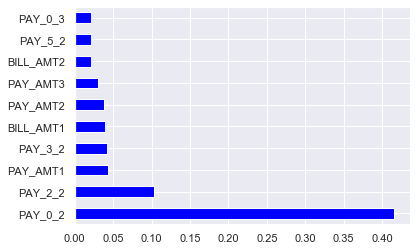

<Figure size 1440x1440 with 0 Axes>

In [522]:
feature_importances = pd.Series(Pickeled_GS_GB.best_estimator_.feature_importances_,index = columns_)
feature_importances.nlargest(10).plot(kind='barh',color = ['blue'])
plt.figure(figsize = (20,20))
plt.show()

In [523]:
feature_importances

BILL_AMT1    0.039872
BILL_AMT2    0.021376
BILL_AMT3    0.016905
BILL_AMT4    0.017518
BILL_AMT5    0.014195
               ...   
PAY_6_4      0.000313
PAY_6_5      0.000127
PAY_6_6      0.001634
PAY_6_7      0.000000
PAY_6_8      0.000243
Length: 78, dtype: float64

In [451]:
score = Pickeled_GS_GB.best_score_
roc=roc_auc_score(y_test, GB_GS_Prediction)
acc = accuracy_score(y_test, GB_GS_Prediction)
prec = precision_score(y_test, GB_GS_Prediction)
rec = recall_score(y_test, GB_GS_Prediction)
f1 = f1_score(y_test, GB_GS_Prediction)

GB_GS_result= pd.DataFrame([['Gradient Boosted Machine-Tuned',score, acc,prec,rec, f1,roc]],
               columns = ['Model', 'Train Accuracy','Test Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])
model_results = model_results.append(GB_GS_result, ignore_index = True)


In [452]:
model_results


,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC
0,RANDOM FOREST,0.803810,0.808111,0.593427,0.328141,0.422601,0.633466
1,DECISION TREE,0.721619,0.729111,0.377159,0.408100,0.392020,0.612305
2,SUPPORT VECTOR MACHINE,0.816810,0.825111,0.692560,0.328660,0.445775,0.644469
3,k-NEAREST NEIGHBOR,0.791524,0.799556,0.548957,0.355140,0.431274,0.637847
4,Gradient Boosted Model,0.816905,0.825667,0.668555,0.367601,0.431274,0.658991
5,Recursive Feature Elimination-GBM,0.813762,0.823444,0.664070,0.354102,0.461903,0.652666
6,PCA-GBM,0.816905,0.825667,0.668555,0.367601,0.474372,0.658991
7,Random Forest-GS-Tuned,0.815000,0.821333,0.639719,0.377985,0.475196,0.660013
8,Support Vector Machine-GS-Tuned,0.817048,0.825333,0.694079,0.328660,0.446089,0.644610
9,k-Nearest Neighbor-Tuned,0.793381,0.807778,0.618932,0.264798,0.370909,0.610205


In [364]:
#Model_Accu = model_results.loc[:,'Model':'Accuracy']
#Model_Accu
#ModelAccu = pd.DataFrame(Model_Accu.Accuracy.values.reshape(1,-1), 
#                    index=['Accuracy'], 
#                    columns=Model_Accu.Model.values)
#ModelAccu

### Comparison of Accuracy of  Baseline Algortithms

In [ ]:
#Box plot of Model's Accuracy 
Accuracy_RF = cross_val_score(Pickeled_RF, X_train, y_train)
Accuracy_DT = cross_val_score(Pickeled_DT, X_train, y_train)
Accuracy_SVM = cross_val_score(Pickeled_SVM, X_train, y_train)
Accuracy_KNN = cross_val_score(Pickeled_KNN, X_train, y_train)
Accuracy_GB = cross_val_score(Pickeled_GB, X_train, y_train)


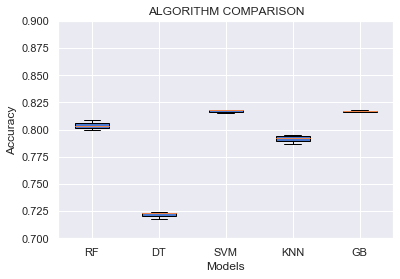

<Figure size 1440x1440 with 0 Axes>

In [390]:
box_plot_data=[Accuracy_RF,Accuracy_DT,Accuracy_SVM,Accuracy_KNN,Accuracy_GB]
plt.boxplot(box_plot_data,patch_artist=True,vert = 0,labels=['RF','DT','SVM','KNN','GB'])
plt.ylim([0.7, 0.9])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('ALGORITHM COMPARISON')
plt.figure(figsize=(20, 20))
plt.show()

### Accuracy comparison of all models

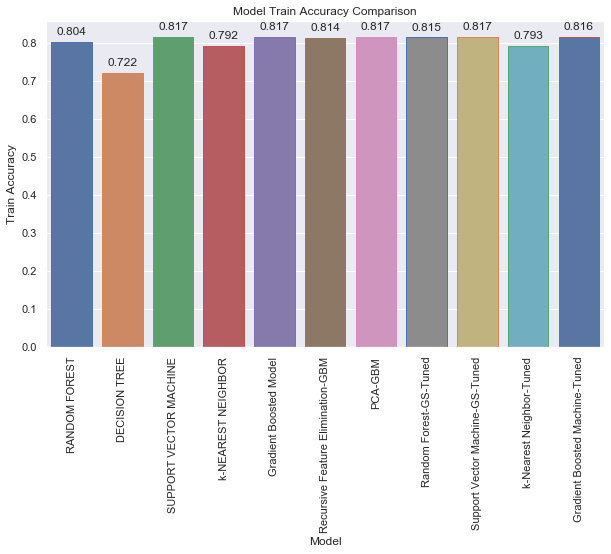

In [535]:
sns.set(color_codes=True)
sns.set_palette("muted")
plt.subplots(figsize=(10,6))
ax = sns.barplot(x="Model", y="Train Accuracy",data=model_results,palette="deep",edgecolor=sns.color_palette('deep',7))
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.3f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(ax)


plt.xticks(rotation=90)
plt.title('Model Train Accuracy Comparison')
plt.show()

####  
* The best accuracy is obtained for the Gradient Boosted Machine-Tuned with a mean accuracy of 0.81, All other models have comparable mean accuracy. Nevertheless, because the classes are imbalanced (the proportion of non-default credit cards is higher than default) this metric is misleading. Furthermore, accuracy does not consider the rate of false positives (non-default credits cards that were predicted as default) and false negatives (default credit cards that were incorrectly predicted as non-default). Both cases have negative impact on the bank, since false positives leads to unsatisfied customers and false negatives leads to financial loss.
* SVM model took a lot of time run when compared to other models.

### ROC/AUC Curve
Area under the receiver operating characteristic curve (“ROC AUC”) is often used to
quantifying the predictive power of machine learning models for binary classification.
The ROC AUC score can take on values from 0 to 1. An ROC AUC score of 0.5 implies
that a model is not predictive. An ROC AUC score of 1 implies that a model is very
predictive.

In [372]:
# false positive rate,fpr= FP/(TN+FP) OR fpr=1-specificty, tpr=sensitivity 
y_pred_RF =Pickeled_RF.predict_proba(X_test)[:,1]
y_pred_SVM =Pickeled_SVM.predict_proba(X_test)[:,1]
y_pred_KNN =Pickeled_KNN.predict_proba(X_test)[:,1]
y_pred_GB = Pickeled_GB.predict_proba(X_test)[:,1]
y_pred_RF_T =Pickeled_GS_RF.predict_proba(X_test)[:,1]
#y_pred_SVM_T =Pickeled_GS_SVM.predict_proba(X_test)[:,1]
y_pred_KNN_T =Pickeled_GS_KNN.predict_proba(X_test)[:,1]
y_pred_GB_T =Pickeled_GS_GB.predict_proba(X_test)[:,1]
y_pred_RFE =Pickeled_rfe.predict_proba(X_test)[:,1]
model = [Pickeled_RF,Pickeled_SVM,Pickeled_KNN,Pickeled_GB,Pickeled_GS_RF,Pickeled_GS_KNN,Pickeled_GS_GB,Pickeled_rfe]
models=[y_pred_RF,y_pred_SVM,y_pred_KNN,y_pred_GB,y_pred_RF_T,y_pred_KNN_T,y_pred_GB_T,y_pred_RFE]
label =['RF','SVM','KNN','GBM','RF-Tuned','KNN-Tuned','GB-Tuned','RFE']

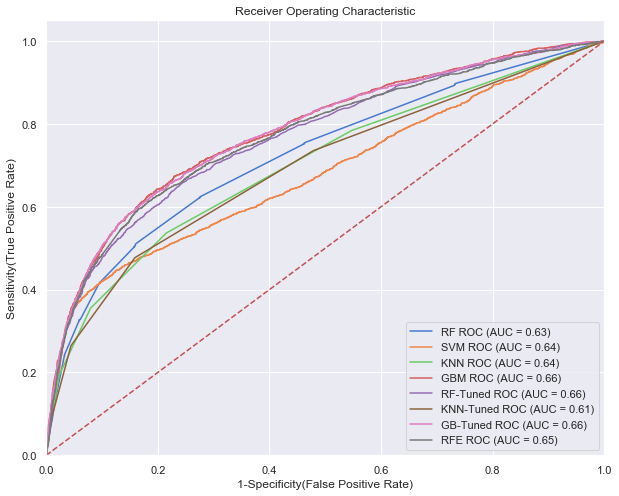

In [507]:
# plotting ROC curves
plt.figure(figsize=(10, 8))
m=np.arange(8)
for m in m:
    fpr, tpr,thresholds= metrics.roc_curve(y_test,models[m])
    auc = metrics.roc_auc_score(y_test,model[m].predict(X_test))
    plt.plot(fpr, tpr, label='%s ROC (AUC = %0.2f)' % (label[m], auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC.png')
plt.show()

#### The highest AUC is obtained for the GBM model, with a value of 0.66. This means there is 66% chance that the model will be able to distinguish between default  and non-default 

### Conclusion

### Based on my analysis, the model selected for best performance would be Gradient Boosted Machine-Tuned 
Parameters: 
({'learning_rate': 0.1, 'n_estimators': 250}. 
Metrics: 

In [525]:
GB_GS_result

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,ROC
0,Gradient Boosted Machine-Tuned,0.81619,0.825222,0.661187,0.375909,0.479311,0.661732


* The most important parameters in determining default of credit cards are the Repayment status variable
* Demographic features didnt have much influence in the predition. 

### Recommendations to increase accuracy and ROC

* Balancing imbalanced dataset.
* Creating new features(Dimensionality reduction)  
* Trying other tree based models and logistic regression
* Hyperparamter Tuning
